In [34]:
from hqa_gan_2.hqa_gan_2 import HQAGAN2
from hqa_gan_1.hqa_gan_1 import HQAGAN
from hqa.hqa_lightning import HQA

import lightning.pytorch as pl

HQA_CHECKPOINT_DIR = '/home/armani/DL_class/hqa/hqa_checkpoints'
HQAGAN_CHECKPOINT_DIR = '/home/armani/DL_class/hqa_gan_1/hqa_gan_1_checkpoints'
HQAGAN_2_CHECKPOINT_DIR = '/home/armani/DL_class/hqa_gan_2/hqa_gan_2_checkpoints'

def load_heirarchical_model_from_checkpoints(
    model_class,
    checkpoints_dir,
    n_layers=5,
    **kwargs
) -> pl.LightningModule:
    """
    Load a HAE model from a directory of checkpoints for each layer
    """
    for layer in range(n_layers):
        if layer == 0:
            hae = model_class.load_from_checkpoint(
                f"{checkpoints_dir}/layer{layer}.ckpt", prev_model=None, **kwargs
            ).eval()
        else:
            hae = model_class.load_from_checkpoint(
                f"{checkpoints_dir}/layer{layer}.ckpt", prev_model=hae_prev, **kwargs
            ).eval()
        hae_prev = hae
    return hae

N_LAYERS = 5


hqa_model = load_heirarchical_model_from_checkpoints(
    HQA,
    HQA_CHECKPOINT_DIR,
    n_layers=N_LAYERS,
    image_channels=1
)

hqagan_model = load_heirarchical_model_from_checkpoints(
    HQAGAN,
    HQAGAN_CHECKPOINT_DIR,
    n_layers=N_LAYERS,
    image_channels=1
)

hqagan2_model = load_heirarchical_model_from_checkpoints(
    HQAGAN2, 
    HQAGAN_2_CHECKPOINT_DIR, 
    n_layers=N_LAYERS,
    image_channels=1
)

In [25]:


from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST


pl.seed_everything(42)

transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
    ]
)
batch_size = 128
ds_train = MNIST('./data/mnist', download=True, train=True, transform=transform)
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4)

ds_test = MNIST('./data/mnist', download=True, train=False, transform=transform)
dl_test = DataLoader(ds_test, batch_size=batch_size, num_workers=4)

Global seed set to 42


In [26]:
import os

import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np

class LeNet(pl.LightningModule):
    def __init__(self, lr):
        super(LeNet, self).__init__()
        self.save_hyperparameters()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(400, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.relu5 = nn.ReLU()

        self.lr = lr

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.reshape(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y
    
    def training_step(self, batch, index):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        self.log('loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, index):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        return loss

    def on_validation_epoch_end(self):
        total = 0
        correct = 0
        self.eval()
        for x, y in dl_test:
            batch_size = y.shape[0]
            y_pred = torch.argmax(classifier(x.to(self.device)), dim=1)
            correct += np.sum((y == y_pred.to('cpu')).numpy())
            total += batch_size
        accuracy = correct / total
        self.log('accuracy', accuracy, prog_bar=True)


    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=self.lr)
        return optimizer

CLASSIFIER_CHECKPOINT = '/home/armani/DL_class/lightning_logs/version_223/checkpoints/epoch=19-step=9380.ckpt'

if not os.path.exists(CLASSIFIER_CHECKPOINT):
    classifier_learning_rate = 1e-1
    classifier = LeNet(lr=classifier_learning_rate)
    #classifier=torch.compile(classifier)
    trainer = pl.Trainer(max_epochs=20, devices=[1])
    trainer.fit(classifier, dl_train, dl_test)
else:
    classifier = LeNet.load_from_checkpoint(CLASSIFIER_CHECKPOINT, lr=1e-1)
    classifier = torch.compile(classifier)



In [27]:
import numpy as np
from tqdm.notebook import tqdm

total = 0
correct = 0

for x, y in tqdm(dl_test):
    batch_size = y.shape[0]
    y_pred = torch.argmax(classifier(x), dim=1)
    correct += np.sum((y == y_pred).numpy())
    total += batch_size

accuracy = correct/total

print('Accuracy on original test set:', accuracy)
print("Correct:", correct)
print("Total:", total)

original_accuracies = np.full(N_LAYERS, accuracy)





  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy on original test set: 0.9884
Correct: 9884
Total: 10000


In [28]:
hqa_accuracies = []

for ndx, hqa_layer in enumerate(hqa_model):
    total = 0
    correct = 0
    for x, y in (prog_bar := tqdm(dl_test)):
        prog_bar.set_description(f"Testing Layer {ndx}")
        batch_size = y.shape[0]
        x = hqa_layer.reconstruct(x)
        y_pred = torch.argmax(classifier(x), dim=1)
        correct += np.sum((y == y_pred).numpy())
        total += batch_size

    accuracy = correct/total
    hqa_accuracies.append(accuracy)
    print("HQA LAYER", ndx)
    print("Accuracy on hqa reconstructions:", accuracy)
    print("Correct:", correct)
    print("Total:", total)

hqa_accuracies = np.array(hqa_accuracies)

  0%|          | 0/79 [00:00<?, ?it/s]

HQA LAYER 0
Accuracy on hqa reconstructions: 0.9821
Correct: 9821
Total: 10000


  0%|          | 0/79 [00:00<?, ?it/s]

HQA LAYER 1
Accuracy on hqa reconstructions: 0.977
Correct: 9770
Total: 10000


  0%|          | 0/79 [00:00<?, ?it/s]

HQA LAYER 2
Accuracy on hqa reconstructions: 0.9391
Correct: 9391
Total: 10000


  0%|          | 0/79 [00:00<?, ?it/s]

HQA LAYER 3
Accuracy on hqa reconstructions: 0.8169
Correct: 8169
Total: 10000


  0%|          | 0/79 [00:00<?, ?it/s]

HQA LAYER 4
Accuracy on hqa reconstructions: 0.2959
Correct: 2959
Total: 10000


In [35]:
hqagan_accuracies = []

for ndx, hqa_layer in enumerate(hqagan_model):
    total = 0
    correct = 0
    for x, y in (prog_bar := tqdm(dl_test)):
        prog_bar.set_description(f"Testing Layer {ndx}")
        batch_size = y.shape[0]
        x = hqa_layer.reconstruct(x)
        y_pred = torch.argmax(classifier(x), dim=1)
        correct += np.sum((y == y_pred).numpy())
        total += batch_size

    accuracy = correct/total
    hqagan_accuracies.append(accuracy)
    print("HQAGAN1 LAYER", ndx)
    print("Accuracy on hqa reconstructions:", accuracy)
    print("Correct:", correct)
    print("Total:", total)

hqagan_accuracies = np.array(hqagan_accuracies)

  0%|          | 0/79 [00:00<?, ?it/s]

HQAGAN1 LAYER 0
Accuracy on hqa reconstructions: 0.9849
Correct: 9849
Total: 10000


  0%|          | 0/79 [00:00<?, ?it/s]

HQAGAN1 LAYER 1
Accuracy on hqa reconstructions: 0.9149
Correct: 9149
Total: 10000


  0%|          | 0/79 [00:00<?, ?it/s]

HQAGAN1 LAYER 2
Accuracy on hqa reconstructions: 0.8691
Correct: 8691
Total: 10000


  0%|          | 0/79 [00:00<?, ?it/s]

HQAGAN1 LAYER 3
Accuracy on hqa reconstructions: 0.8022
Correct: 8022
Total: 10000


  0%|          | 0/79 [00:00<?, ?it/s]

HQAGAN1 LAYER 4
Accuracy on hqa reconstructions: 0.3403
Correct: 3403
Total: 10000


In [29]:
hqagan2_accuracies = []

for ndx, hqa_layer in enumerate(hqagan2_model):
    total = 0
    correct = 0
    for x, y in (prog_bar := tqdm(dl_test)):
        prog_bar.set_description(f"Testing Layer {ndx}")
        batch_size = y.shape[0]
        x = hqa_layer.reconstruct(x)
        y_pred = torch.argmax(classifier(x), dim=1)
        correct += np.sum((y == y_pred).numpy())
        total += batch_size

    accuracy = correct/total
    hqagan2_accuracies.append(accuracy)
    print("HQAGAN2 LAYER", ndx)
    print("Accuracy on hqa reconstructions:", accuracy)
    print("Correct:", correct)
    print("Total:", total)

hqagan2_accuracies = np.array(hqagan2_accuracies)

  0%|          | 0/79 [00:00<?, ?it/s]

HQAGAN2 LAYER 0
Accuracy on hqa reconstructions: 0.9874
Correct: 9874
Total: 10000


  0%|          | 0/79 [00:00<?, ?it/s]

HQAGAN2 LAYER 1
Accuracy on hqa reconstructions: 0.1277
Correct: 1277
Total: 10000


  0%|          | 0/79 [00:00<?, ?it/s]

HQAGAN2 LAYER 2
Accuracy on hqa reconstructions: 0.09
Correct: 900
Total: 10000


  0%|          | 0/79 [00:00<?, ?it/s]

HQAGAN2 LAYER 3
Accuracy on hqa reconstructions: 0.0895
Correct: 895
Total: 10000


  0%|          | 0/79 [00:00<?, ?it/s]

HQAGAN2 LAYER 4
Accuracy on hqa reconstructions: 0.1134
Correct: 1134
Total: 10000


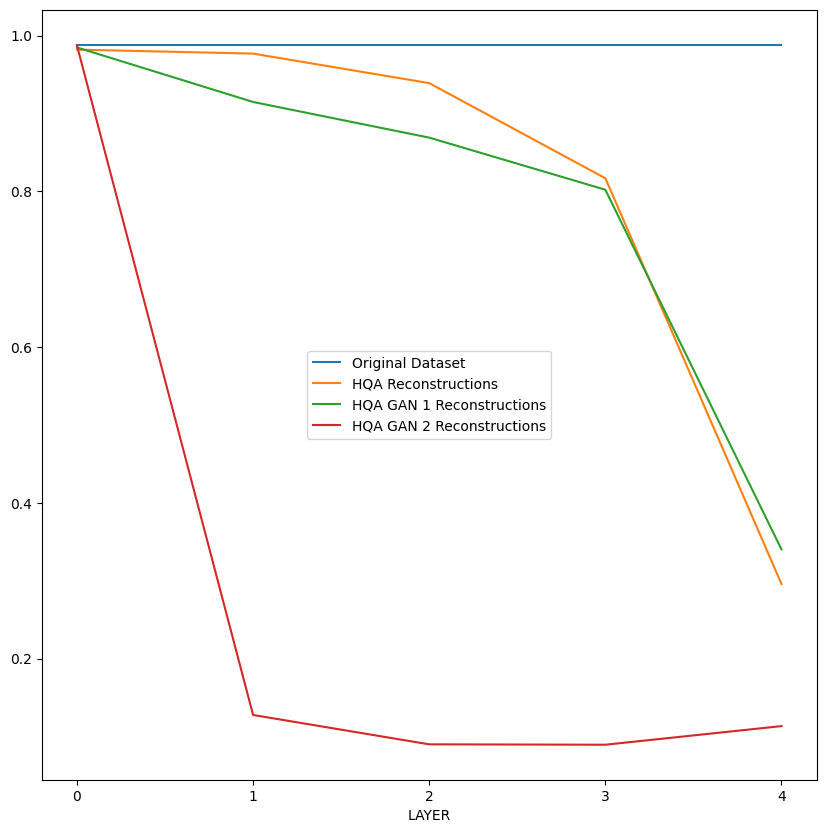

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

plt.plot(original_accuracies, label="Original Dataset")
plt.plot(hqa_accuracies, label="HQA Reconstructions")
plt.plot(hqagan_accuracies, label="HQA GAN 1 Reconstructions")
plt.plot(hqagan2_accuracies, label="HQA GAN 2 Reconstructions")

plt.xticks(np.arange(0, N_LAYERS))
plt.xlabel("Layer")
plt.ylabel("Accuracy")

plt.legend()